<a href="https://colab.research.google.com/github/UW-ERSL/MaTruss/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import torch
import os, sys
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
sys.path.append(os.path.realpath('./src/'))
from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder


import seaborn as sns
import scipy as sp

### Read material properties from the database. The properties are then scaled to facilitate training

In [2]:
def preprocessData():
  #Chooses the database to extract the properties from
  df = pd.read_excel('./data/solidworksMaterialDatabase.xlsx')
  #Gets name, class and class number of each material
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]}
  #Gets in logarithmic from the values of the properties of each material
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  #Scales the properties and normalize them to train the VAE equally among all properties
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  #Gets the normalized values
  trainingData = torch.tensor(normalizedData).float()
  #Gets an array with the minimum and maximum values of each properties
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]}}
    
  return trainingData, dataInfo, dataIdentifier, trainInfo
trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
#Gets number of materials and number of properties
numMaterialsInTrainingData, numFeatures = trainingData.shape

C:\Users\luisy\AppData\Local\Temp\ipykernel_15284\3979330233.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


### VAE training

In [3]:
#Defines the dimension of the latent space and the number of neurons
latentDim, hiddenDim = 3, 250
#Defines a maximum of itrations
numEpochs = 50000
#Defines a klFactor
klFactor = 5e-5
#Defines a learning rate
learningRate = 2e-3
#Defines the stopping criteria
epsilon=4.1e-2
#Sets where to save the vaeNet
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
#Loads the encoder from src\materialEncoder.py
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
#Runs the the trainAutoencoder function from src\materialEncoder.py
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate,epsilon)
print('training time : {:.2F}'.format(time.perf_counter() - start))

Iter 0 reconLoss 3.17E+01 klLoss 1.15E-02 loss 3.17E+01
Iter 500 reconLoss 9.61E-02 klLoss 7.17E-02 loss 1.68E-01
Iter 1000 reconLoss 6.05E-02 klLoss 6.53E-02 loss 1.26E-01
Iter 1500 reconLoss 3.61E-02 klLoss 6.19E-02 loss 9.80E-02
Iter 2000 reconLoss 2.73E-02 klLoss 5.97E-02 loss 8.70E-02
Iter 2500 reconLoss 2.39E-02 klLoss 5.82E-02 loss 8.21E-02
Iter 3000 reconLoss 2.00E-02 klLoss 5.70E-02 loss 7.69E-02
Iter 3500 reconLoss 1.67E-02 klLoss 5.63E-02 loss 7.30E-02
Iter 4000 reconLoss 1.82E-02 klLoss 5.52E-02 loss 7.34E-02
Iter 4500 reconLoss 1.45E-02 klLoss 5.47E-02 loss 6.92E-02
Iter 5000 reconLoss 1.37E-02 klLoss 5.35E-02 loss 6.72E-02
Iter 5500 reconLoss 1.37E-02 klLoss 5.26E-02 loss 6.63E-02
Iter 6000 reconLoss 1.30E-02 klLoss 5.26E-02 loss 6.55E-02
Iter 6500 reconLoss 1.22E-02 klLoss 5.12E-02 loss 6.34E-02
Iter 7000 reconLoss 1.13E-02 klLoss 5.05E-02 loss 6.19E-02
Iter 7500 reconLoss 1.53E-02 klLoss 5.08E-02 loss 6.62E-02
Iter 8000 reconLoss 1.15E-02 klLoss 4.99E-02 loss 6.13E-02
I

In [4]:
plt.close('all')

## PLots loss evolution

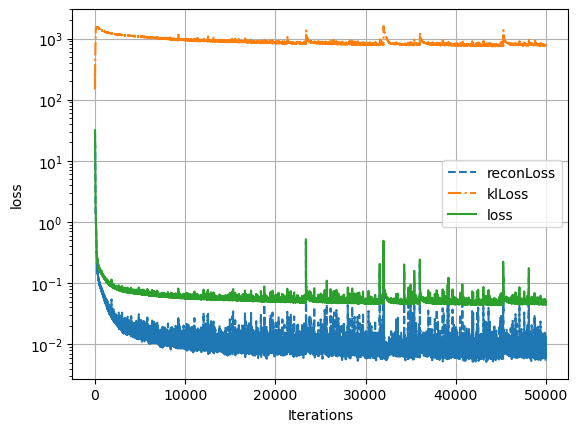

In [5]:
# Moving average convergence plots
def plotConvergence(convg):
  plt.figure();
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    
    y = np.array(convg[key])
    y_mvavg = np.convolve(y, np.ones(1), 'valid') / 1.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend()
    plt.savefig('./figures/convergence.pdf')

plotConvergence(convgHistory)

## Measure differences between input and output of the trained VAE

In [6]:
matidxs = np.array([2,11,19,45,53,68,73,4,77]).astype(int)-2
props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
print([dataIdentifier['name'][i] for i in matidxs])
print('\t \t ------TRUE DATA----------')
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
for i in matidxs:
  print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    print('\t {:.2E}'.format(10.**trainInfo[i,idx]),end='')

def unnormalize(val, minval ,maxval):
  return 10.**(minval + (maxval-minval)*val)
def decodeAll():
  vae = materialEncoder.vaeNet
  decoded = vae.decoder(vae.encoder.z)
  matProp = {'youngsModulus':None,'costPerKg':None,'massDensity':None,'yieldStrength':None}
  for k in props:
    idx = materialEncoder.dataInfo[k]['idx']
    scaleMax = materialEncoder.dataInfo[k]['scaleMax']
    scaleMin = materialEncoder.dataInfo[k]['scaleMin']
    matProp[k] = unnormalize(decoded[:,idx], scaleMin ,scaleMax)
  return matProp

matProp = decodeAll()
print('\n \n \t \t ------RECONSTRUCTED DATA----------') 
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
  
for i in matidxs:
  print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    print('\t {:.2E}'.format(matProp[p][i]), end='')

merr = -1000000000.
maxError = {'youngsModulus':merr,'costPerKg':merr,'massDensity':merr,'yieldStrength':merr}
print('\n \n \t \t ------RECON ERROR (%)----------') 
print('material name', end = '\t')
acum_error=np.zeros(4)
for p in props:
    print(p, end = '\t')
for i in range(trainInfo.shape[0]):
  if(i in matidxs): #
    print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData)
    acum_error[idx]=acum_error[idx]+err
    if(err > maxError[p]):
      maxError[p] = err
    if(i in matidxs):
      print('\t {:.1F}'.format(err), end='')
      
print('\n\033[1;31m max Error \t \033[0m', end = '')
for p in props:
  print('\033[1;31m \t {:.1F} \033[0m'.format(maxError[p]), end='')
print('\n\033[1;31m avg Error \t \033[0m', end='')
for p in props:
  idx = materialEncoder.dataInfo[p]['idx']
  print('\033[1;31m \t {:.1F} \033[0m'.format(acum_error[idx]/trainInfo.shape[0]), end='')

['A286 Iron', 'AISI 304', 'Gray Cast Iron', '3003-H16', '5052-O', '7050-T7651', 'Acrylic', 'ABS', 'PE HD']
	 	 ------TRUE DATA----------
material name	youngsModulus	costPerKg	massDensity	yieldStrength	
 A286 Iron 	 	 2.01E+11	 5.18E+00	 7.92E+03	 6.20E+08
 AISI 304 	 	 1.90E+11	 2.40E+00	 8.00E+03	 5.17E+08
 Gray Cast Iron 	 	 6.62E+10	 6.48E-01	 7.20E+03	 1.52E+08
 3003-H16 	 	 6.90E+10	 2.18E+00	 2.73E+03	 1.80E+08
 5052-O 	 	 7.00E+10	 2.23E+00	 2.68E+03	 1.95E+08
 7050-T7651 	 	 7.20E+10	 2.33E+00	 2.83E+03	 5.50E+08
 Acrylic 	 	 3.00E+09	 2.80E+00	 1.20E+03	 7.30E+07
 ABS 	 	 2.00E+09	 2.91E+00	 1.02E+03	 3.00E+07
 PE HD 	 	 1.07E+09	 2.21E+00	 9.52E+02	 2.21E+07
 
 	 	 ------RECONSTRUCTED DATA----------
material name	youngsModulus	costPerKg	massDensity	yieldStrength	
 A286 Iron 	 	 1.99E+11	 5.07E+00	 7.83E+03	 6.27E+08
 AISI 304 	 	 2.03E+11	 2.27E+00	 7.95E+03	 5.27E+08
 Gray Cast Iron 	 	 6.73E+10	 6.62E-01	 7.23E+03	 1.49E+08
 3003-H16 	 	 7.04E+10	 2.25E+00	 2.74E+03	 1.83E+

## Measures distance between materials based on their euclidean distance in the latent space

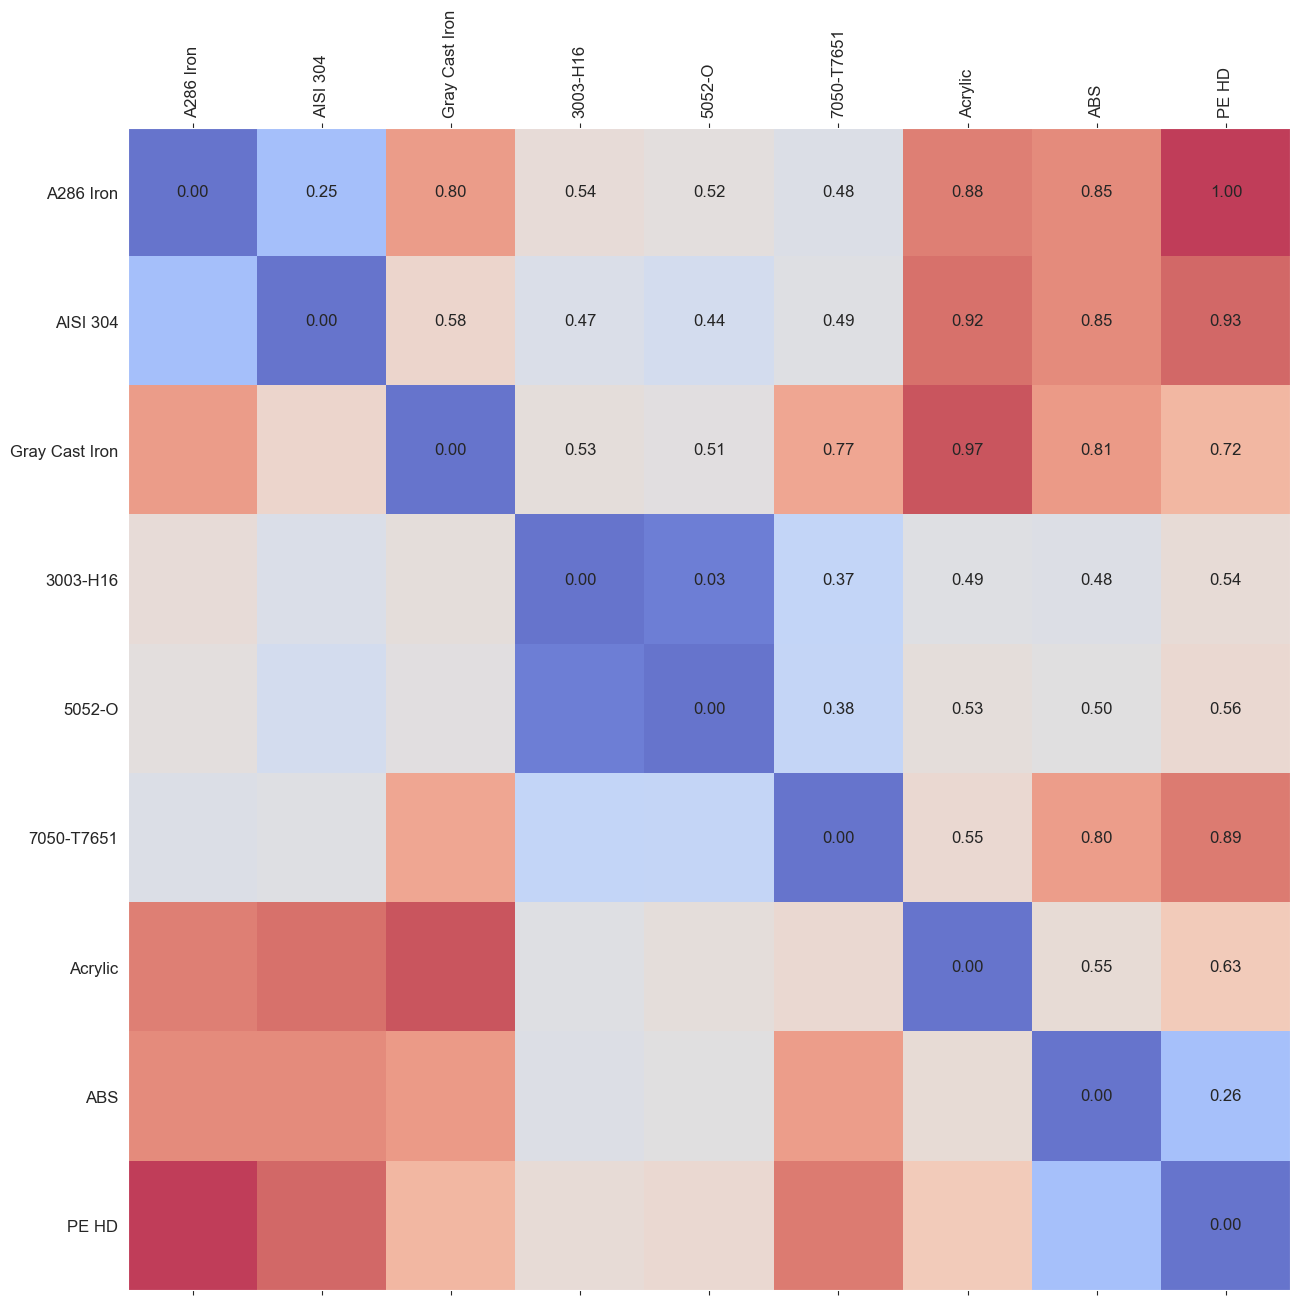

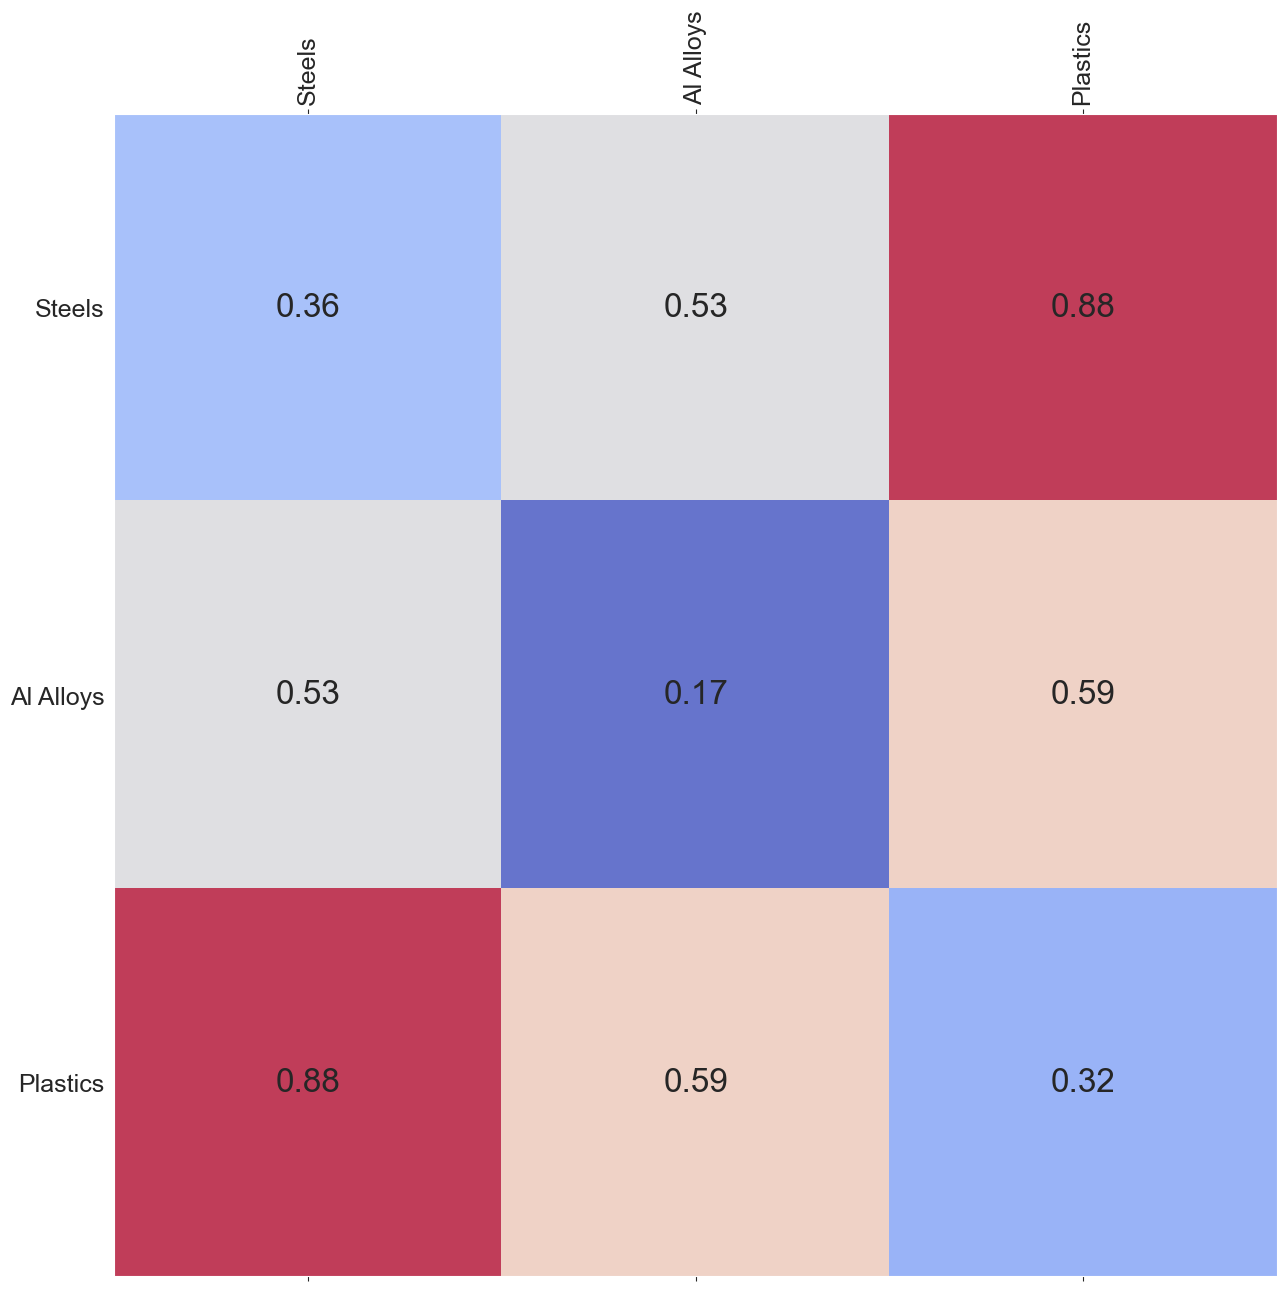

In [7]:
# distance matrix between a select candidate of materials
def drawDistanceMatrix():
  #List of materials, which are by default 3 steels, 3 aluminiums and 3 plastics
  matidxs = np.array([2,11,19,45,53,68,73,4,77]).astype(int)-2 # the rows of mats to consider in the db
  distMatrix = np.zeros((len(matidxs),)*2)
  sns.set_style("dark")
  #Loads the VAE
  vae = materialEncoder.vaeNet
  #Loads latent space coordinates of the materials
  z_np = to_np(vae.encoder.z)
  for rw in range(len(matidxs)):
    for col in range(rw, len(matidxs)):
      mx, my = matidxs[rw], matidxs[col]
      #Gets the euclidean norm from the z coordinates
      distMatrix[rw,col] = np.linalg.norm(z_np[mx,:] - z_np[my,:])
      distMatrix[col,rw] = distMatrix[rw,col]
  #Gets the maximum value of distance so that is used to scale the maximum value to 1
  maxval = np.max(distMatrix)

  distMatrix = distMatrix/maxval

  matplotlib.rcParams['figure.figsize'] = (15, 15)
  plt.matshow(distMatrix,cmap="coolwarm", alpha = 0.75)

  ax = plt.gca()

  # Set the plot labels
  xlabels = [dataIdentifier['name'][i] for i in matidxs]
  ax.set_xticks(range(len(matidxs)))
  ax.set_xticklabels(xlabels, rotation = 90, size = 12)
  ax.set_yticks(range(len(matidxs)))
  ax.set_yticklabels(xlabels, size = 12)
  plt.grid(which='minor',c='indigo', ls='-', lw='5.8')
  

  #Add text to the plot showing the values at that point
  for i in range(len(matidxs)):
      for j in range(i,len(matidxs)):
          pltText = '{:.2F}'.format(distMatrix[i,j])
          plt.text(j,i, pltText, horizontalalignment='center', \
                     verticalalignment='center', size = 12)
  plt.savefig('./figures/distanceMatrix.pdf',bbox_inches='tight', dpi = 200)
  plt.show()
  

  #Now gets an average distance among the 3 materials of each group
  avgMatrix = np.zeros((3,3))
  for i in range(3):
    for j in range(3):
      avgMatrix[i,j] = np.mean(distMatrix[3*i:3*(i+1), 3*j:3*(j+1)])
  
  
  
  plt.matshow(avgMatrix,cmap="coolwarm", alpha = 0.75)
  ax = plt.gca()
  for i in range(3):
    for j in range(3):
        pltText = '{:.2F}'.format(avgMatrix[i,j])
        plt.text(j,i, pltText, horizontalalignment='center', \
                   verticalalignment='center', size = 24)
  xlabels = ['Steels', 'Al Alloys', 'Plastics']
  ax.set_xticks(range(3))
  ax.set_xticklabels(xlabels, rotation = 90, size = 18)
  ax.set_yticks(range(3))
  ax.set_yticklabels(xlabels, size = 18)
  plt.savefig('./figures/averageDistanceMatrix.pdf',bbox_inches='tight')
drawDistanceMatrix()


## Plots the latent field in 3D

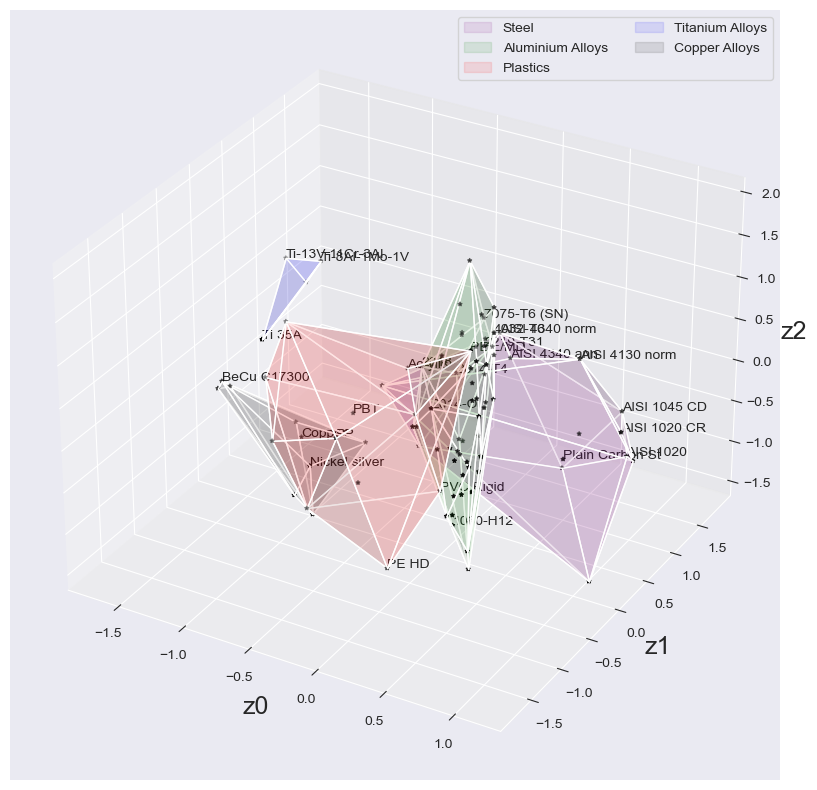

In [16]:
# The latent field
def plotLatent3D(saveFileName):
    #Define a set of colors
    clrs = ['purple', 'green', 'red', 'blue', 'black', 'violet', 'cyan',]
    #Gets a mx1 vector containing the ClassID of each material 
    colorcol = dataIdentifier['classID']
    #Gets a mx1 vector containing the name of each material
    ptLabel = dataIdentifier['name']
    #Loads the encoder
    autoencoder = materialEncoder.vaeNet
    #mxdimensions matrix containing coordinates of z for each material
    z = autoencoder.encoder.z.to('cpu').detach().numpy() 
    
    #Create the figure
    fig = plt.figure()
    #Set the plot as 3d
    ax = plt.axes(projection ="3d")
    #Gets a 1xm vector wich is the list written substracting 2 to each member
    matidxs = np.array([13,14,15,48,18,10,9,8,28,20,30,69,27,37,\
                        5,6,73,77,78,85,91,88,75,80,82,83]).astype(int)-2 
    
    #Creates the patches array for the legend
    patches=[]
    #One iteration for each material class. As it starts at 0, it must run 5 times to get the class nº4
    for i in range(np.max(colorcol)+1): 
        #For each material class, puts in zMat its z coordinates ordered following the database
        zMat = np.vstack((z[colorcol == i,0], z[colorcol == i,1], z[colorcol == i,2])).T
        #print(zMat)
        #Displays the materials as black points in the latent space  
        ax.scatter3D(zMat[:, 0], zMat[:, 1], zMat[:, 2], marker='*', c = 'black', s = 8) #clrs[i]

        #If the plotHull option is activated, will create a convexhull around those points

        hull = ConvexHull(zMat)

        #Gets the center of the convex hull
        cent = np.mean(zMat, 0)

        # Plot the facets of the hull as triangles
        for simplex in hull.simplices:
            # Define the vertices of the facet
            vertices = zMat[simplex, :]
            # Plot the facet as a triangle
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=clrs[i], alpha=0.1)

        # Set the labels and limits of the axes
        ax.set_xlabel('z0', size = 18)
        ax.set_ylabel('z1', size = 18)
        ax.set_zlabel('z2', size = 18)
        # Creates personalised legend by color and material class
        patches.append(mpatches.Patch(color=clrs[i], alpha=0.1, label=dataIdentifier['className'][i]))
    plt.legend(handles=patches, ncol=2)
    # Plots the name of the materials listed in matidxs
    for i, txt in enumerate(ptLabel):
      if(i in matidxs):
        
        # continue
        ax.text(z[i,0], z[i,1], z[i,2], txt)


    #ax.view_init(90, -90)
    return fig, ax
  
plotLatent3D(saveFileName = './figures/latent3D.pdf');

## Plots the latent space cut by plane in 2D with a Convex Hull

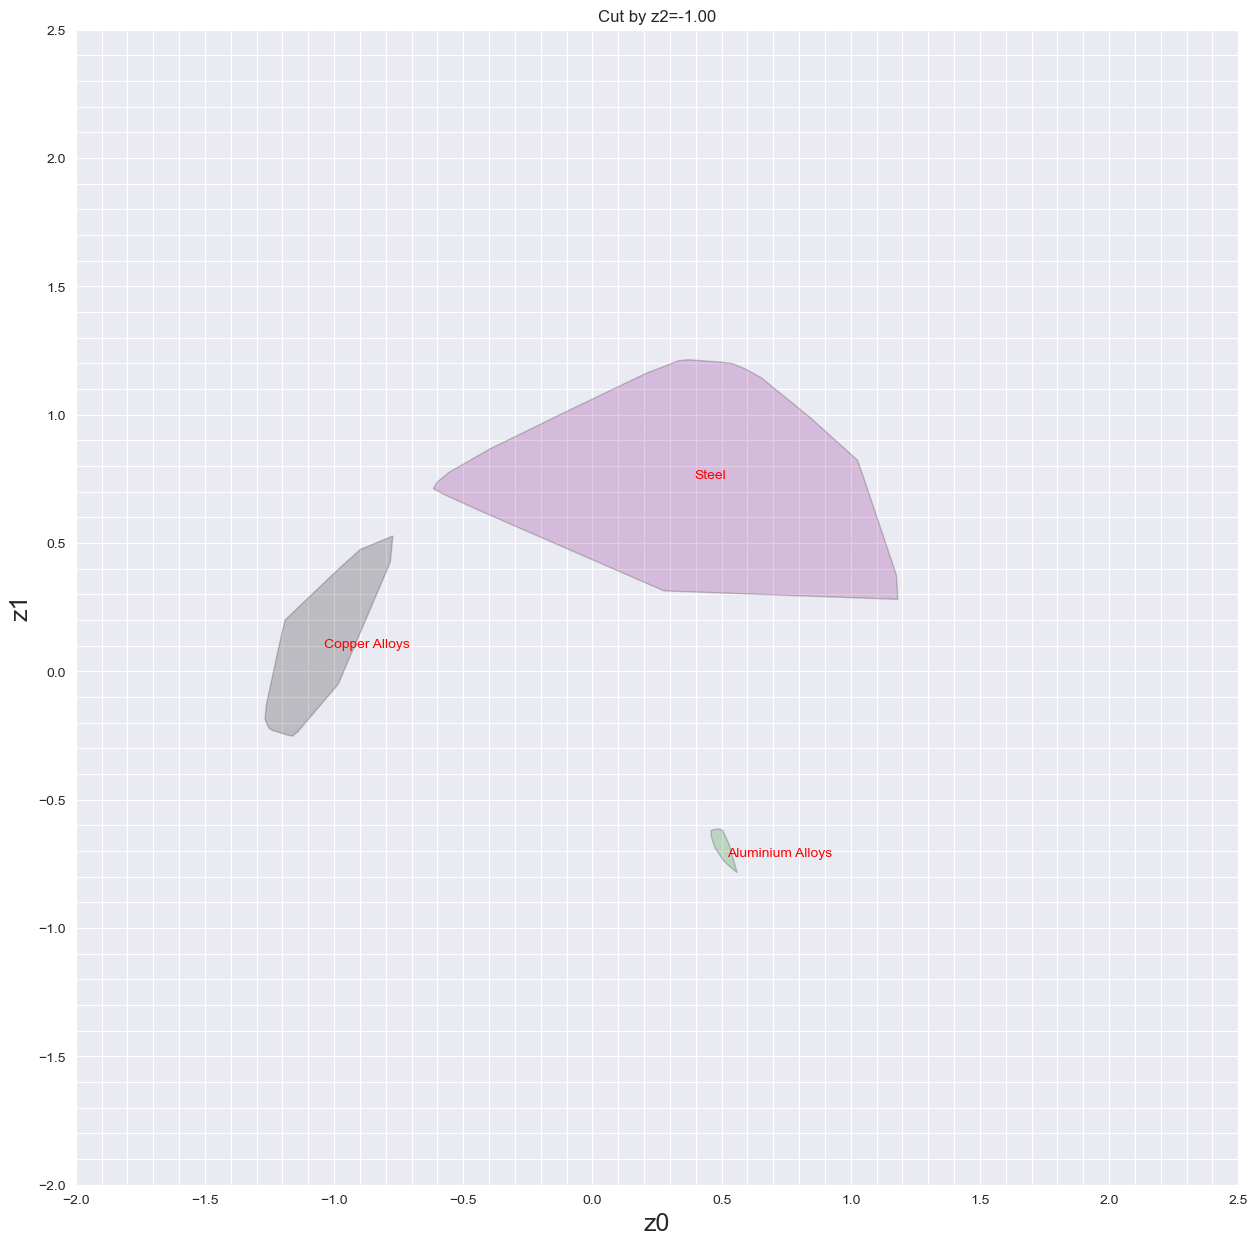

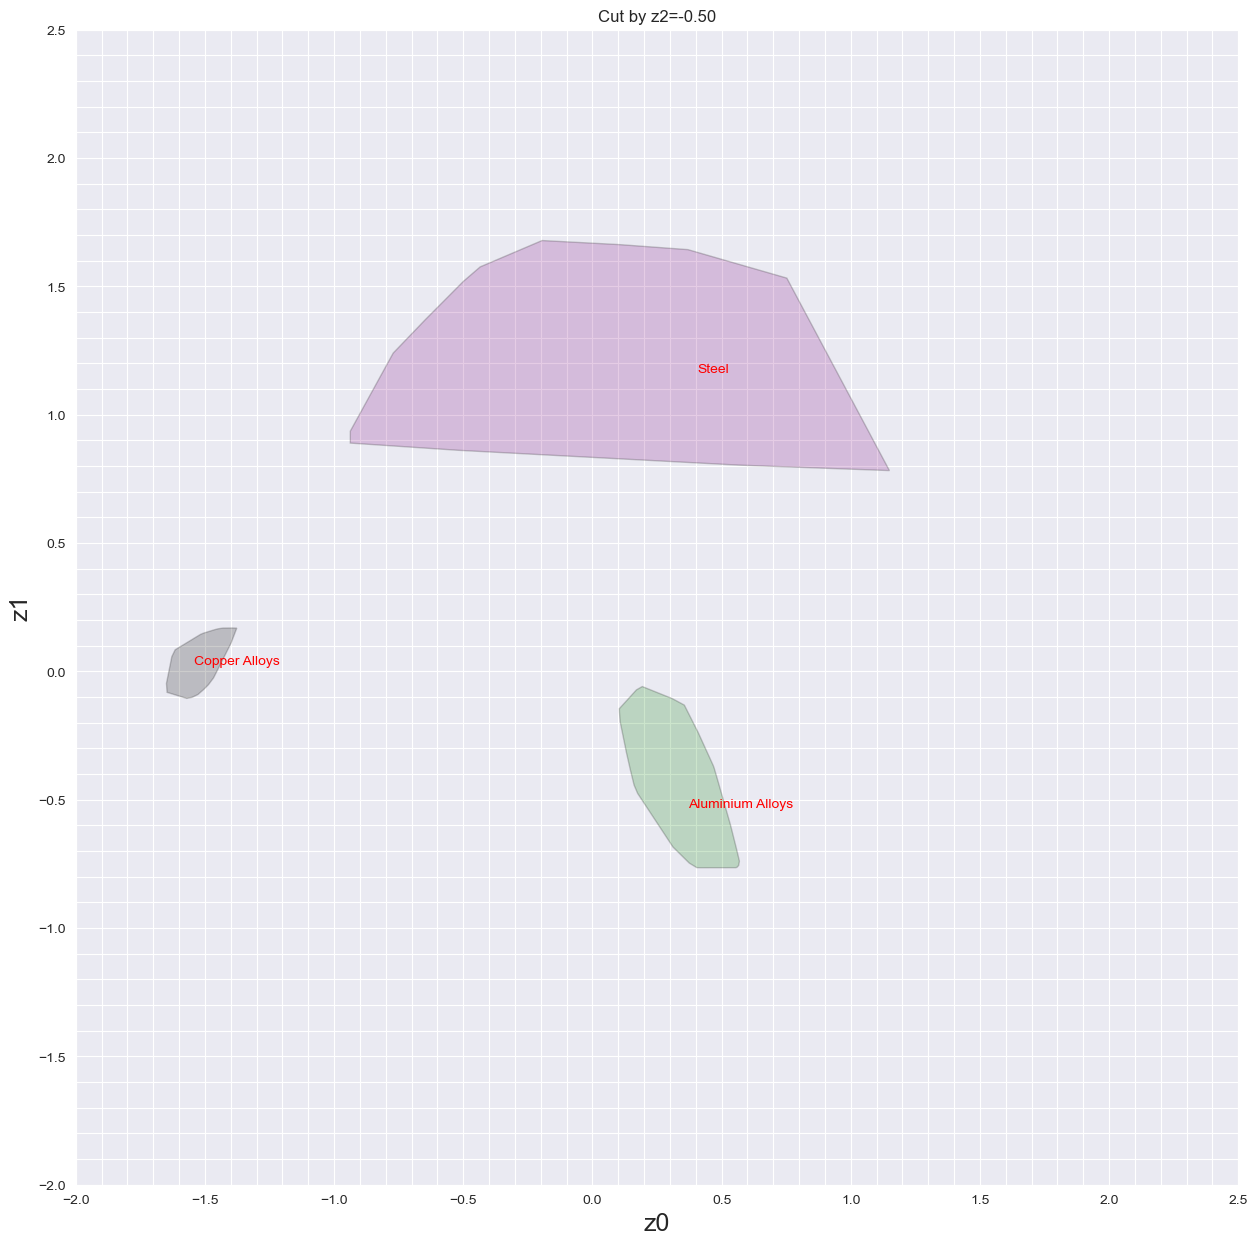

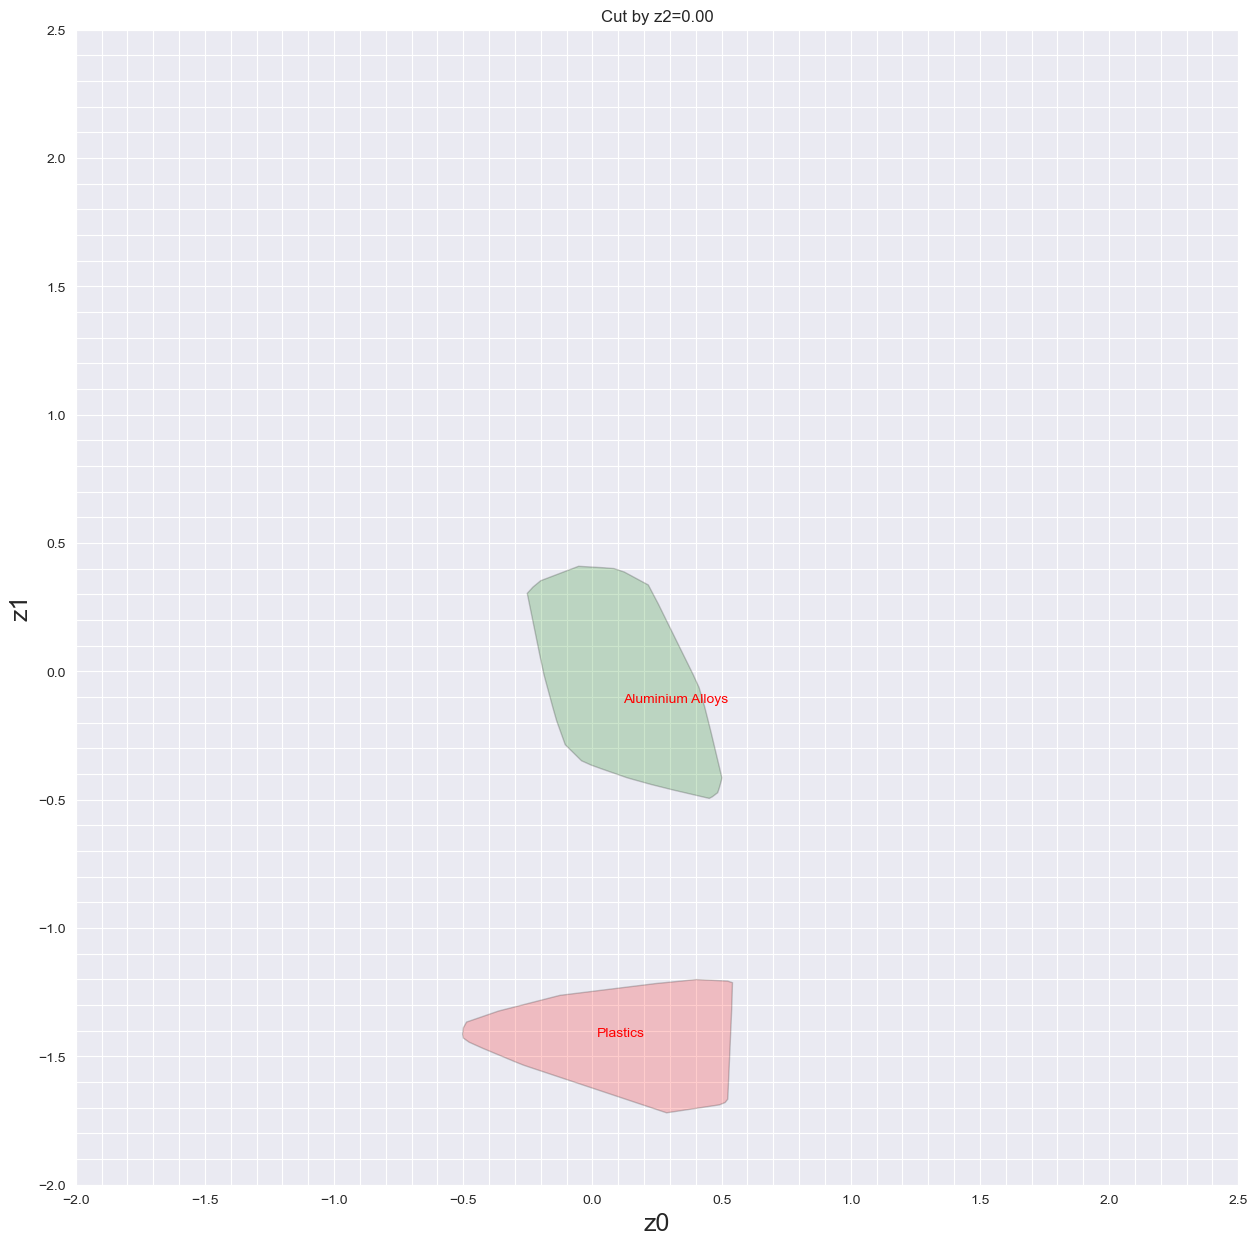

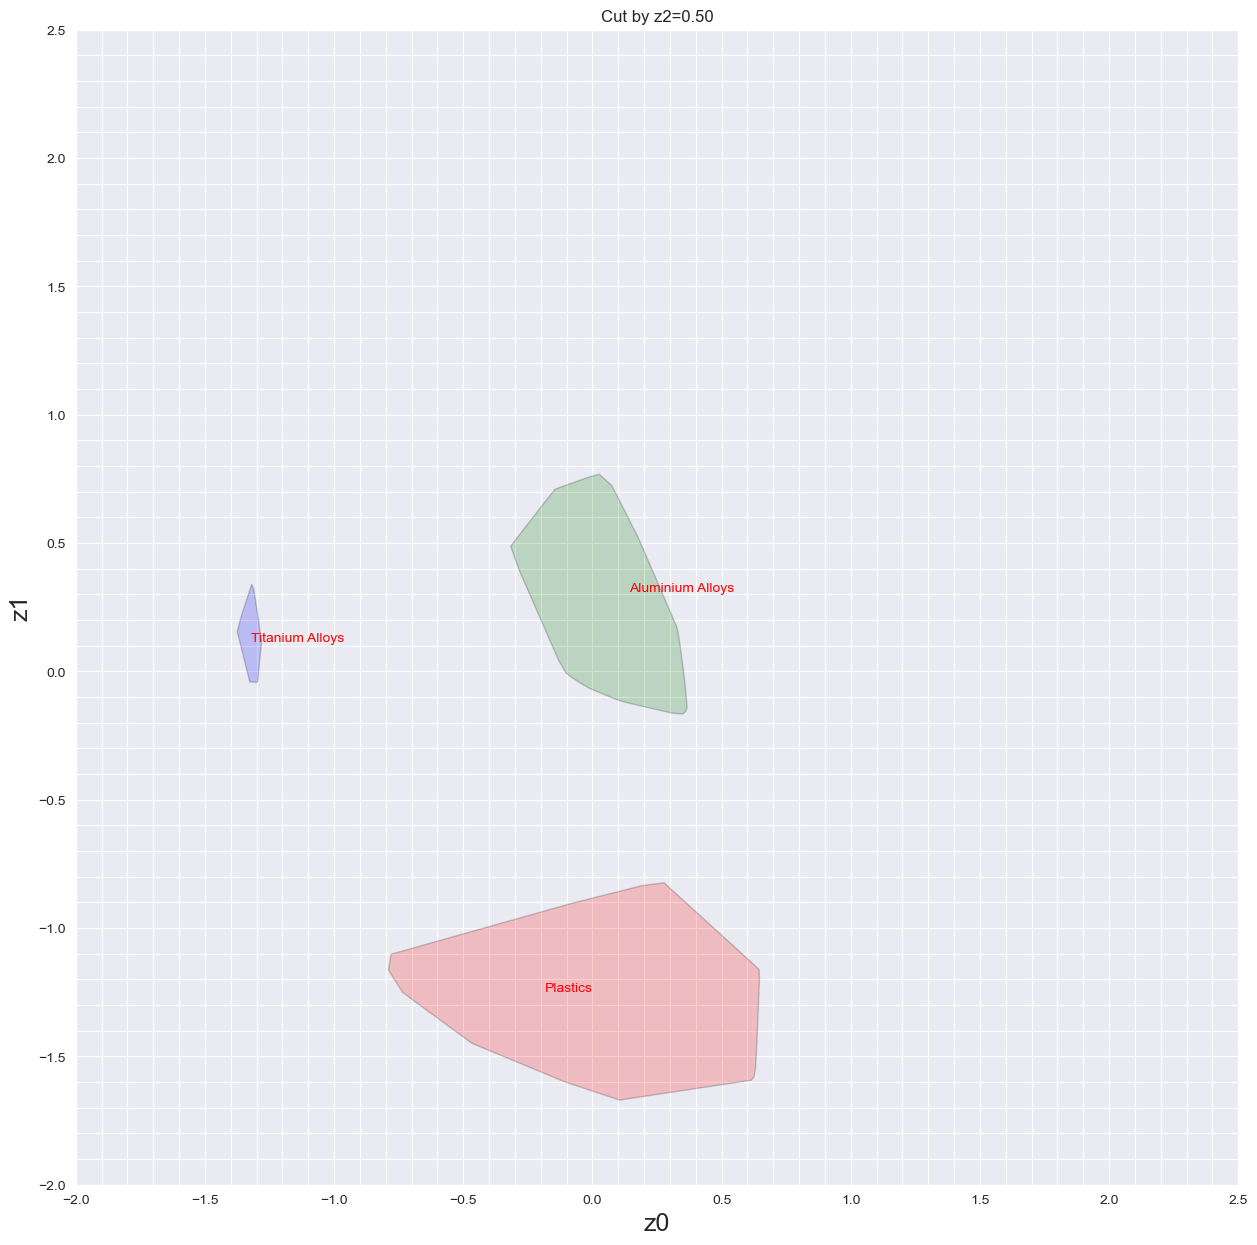

In [19]:
def plotLatentProy(zp, saveFileName):
    #Define a set of colors
    clrs = ['purple', 'green', 'red', 'blue', 'black', 'violet', 'cyan',]
    #Gets a mx1 vector containing the ClassID of each material 
    colorcol = dataIdentifier['classID']
    #Gets a mx1 vector containing the name of each material
    ptLabel = dataIdentifier['name']
    #Loads the encoder
    autoencoder = materialEncoder.vaeNet
    #mxdimensions matrix containing coordinates of z for each material
    z = autoencoder.encoder.z.to('cpu').detach().numpy() 
    # Define the plane o cut in 3D space
    plane_origin = np.array([0, 0, zp])
    plane_normal = np.array([0,0,1]) 
    fig = plt.figure()
    #Set the plot as 2d
    ax = plt.axes()
    #One iteration for each material class. As it starts at 0, it must run 5 times to get the class nº4
    for i in range(np.max(colorcol)+1): 
        #For each material class, puts in zMat its z coordinates ordered following the database
        zMat = np.vstack((z[colorcol == i,0], z[colorcol == i,1], z[colorcol == i,2])).T

        hull = ConvexHull(zMat)
        # Generate more points on the edges of the convex hull
        n = 40  # number of points to generate on each edge
        new_points = []
        for simplex in hull.simplices:
            a, b, c = zMat[simplex]
            # Generate n points between each pair of vertices
            for o in range(n):
                for j in range(n - o):
                    k = n - o - j
                    new_points.append([o / n * a + j / n * b + k / n * c])
        new_points = np.vstack(new_points)

        all_points = np.vstack([zMat, new_points])

        # Calculate the distance between each point and the plane
        distances = np.abs(np.dot(all_points - plane_origin, plane_normal))
        # Set a threshold for the distance below which a point is considered "close" to the plane
        threshold = 0.05

        # Select the points that are close to the plane
        close_points = all_points[distances < threshold]
        close_points = close_points[:,0:2]
        if len(close_points) > 0:
            #creates the Hull
            hull = ConvexHull(close_points)
            cent = np.mean(close_points, 0)
            pts = []
            for pt in close_points[hull.simplices]:
                pts.append(pt[0].tolist())
                pts.append(pt[1].tolist())

            #pts is vertices of the convexhull
            pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                            p[0] - cent[0]))
            pts = pts[0::2]  # Deleting duplicates
            pts.insert(len(pts), pts[0])
            poly = Polygon(1.1*(np.array(pts)- cent) + cent,
                           facecolor= clrs[i], alpha=0.2, edgecolor = 'black') #'black'
            poly.set_capstyle('round')
            plt.gca().add_patch(poly)
            ax.annotate(dataIdentifier['className'][i], (cent[0], cent[1]), size = 10, c = 'red')


    # Set x and y limits
    ax.set_xlim([-2, 2.5])
    ax.set_ylim([-2, 2.5])
    ax.set_xlabel('z0', size = 18)
    ax.set_ylabel('z1', size = 18)
    # Set minor ticks
    minor_ticks = np.arange(-2, 2.5, 0.1)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)

    # Show minor grid lines
    plt.grid(which='both')
    plt.title('Cut by z2={:.2f}'.format(zp))
    plt.savefig(saveFileName)


    return fig, ax

  
plotLatentProy(-1, saveFileName = './figures/latentproy1.pdf');
plotLatentProy(-0.5, saveFileName = './figures/latentproy2.pdf');
plotLatentProy(0, saveFileName = './figures/latentproy3.pdf');
plotLatentProy(0.5, saveFileName = './figures/latentproy4.pdf');

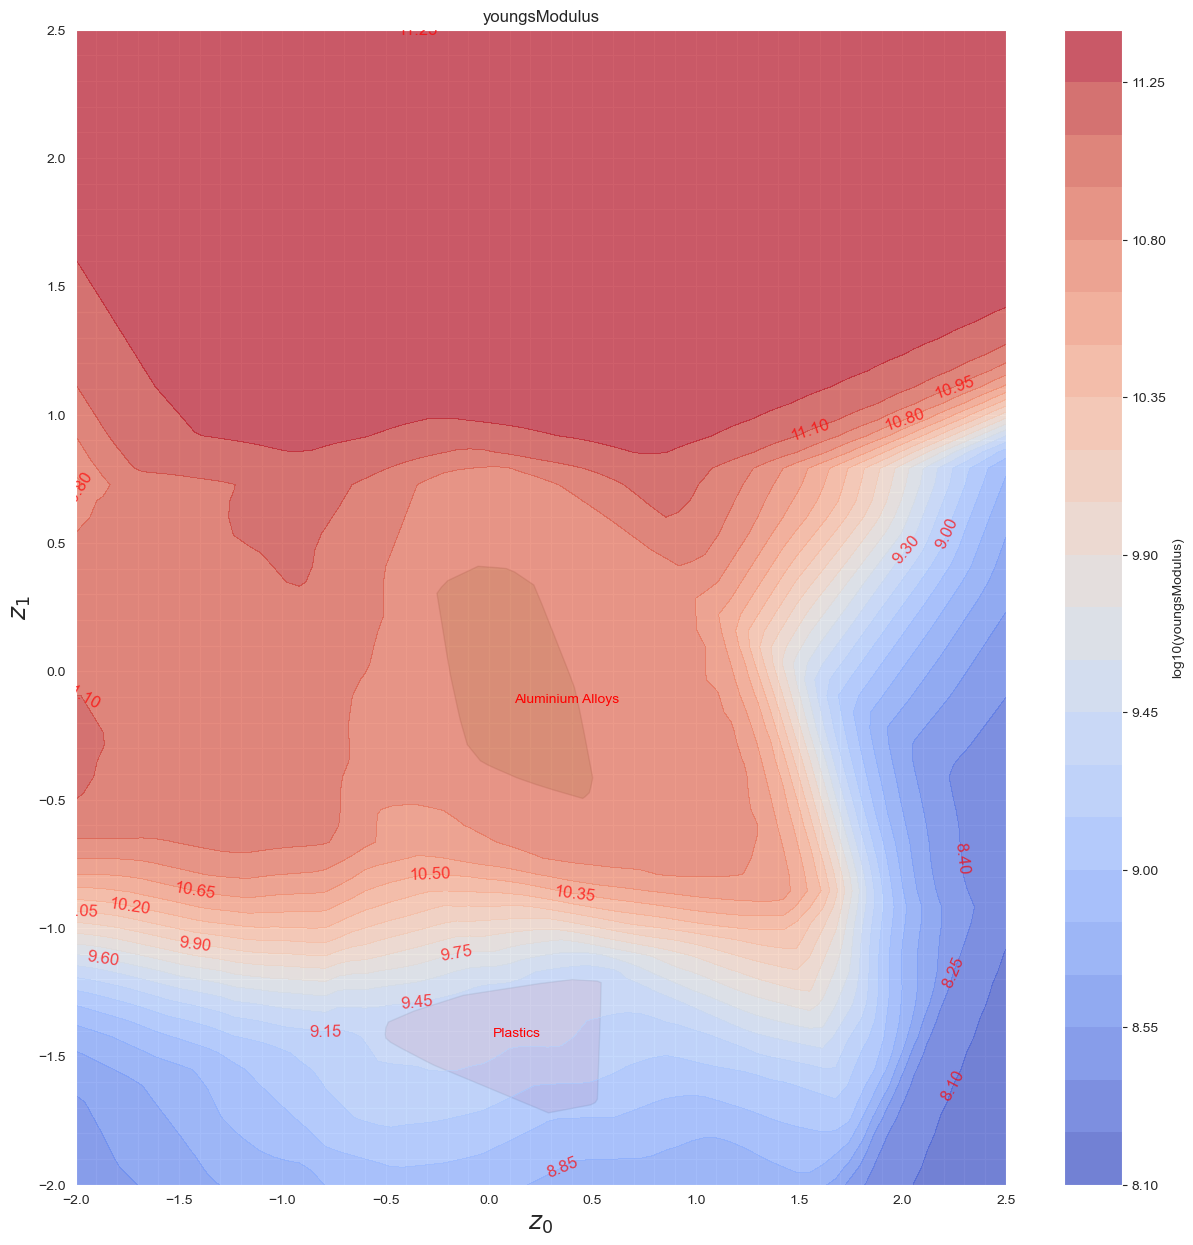

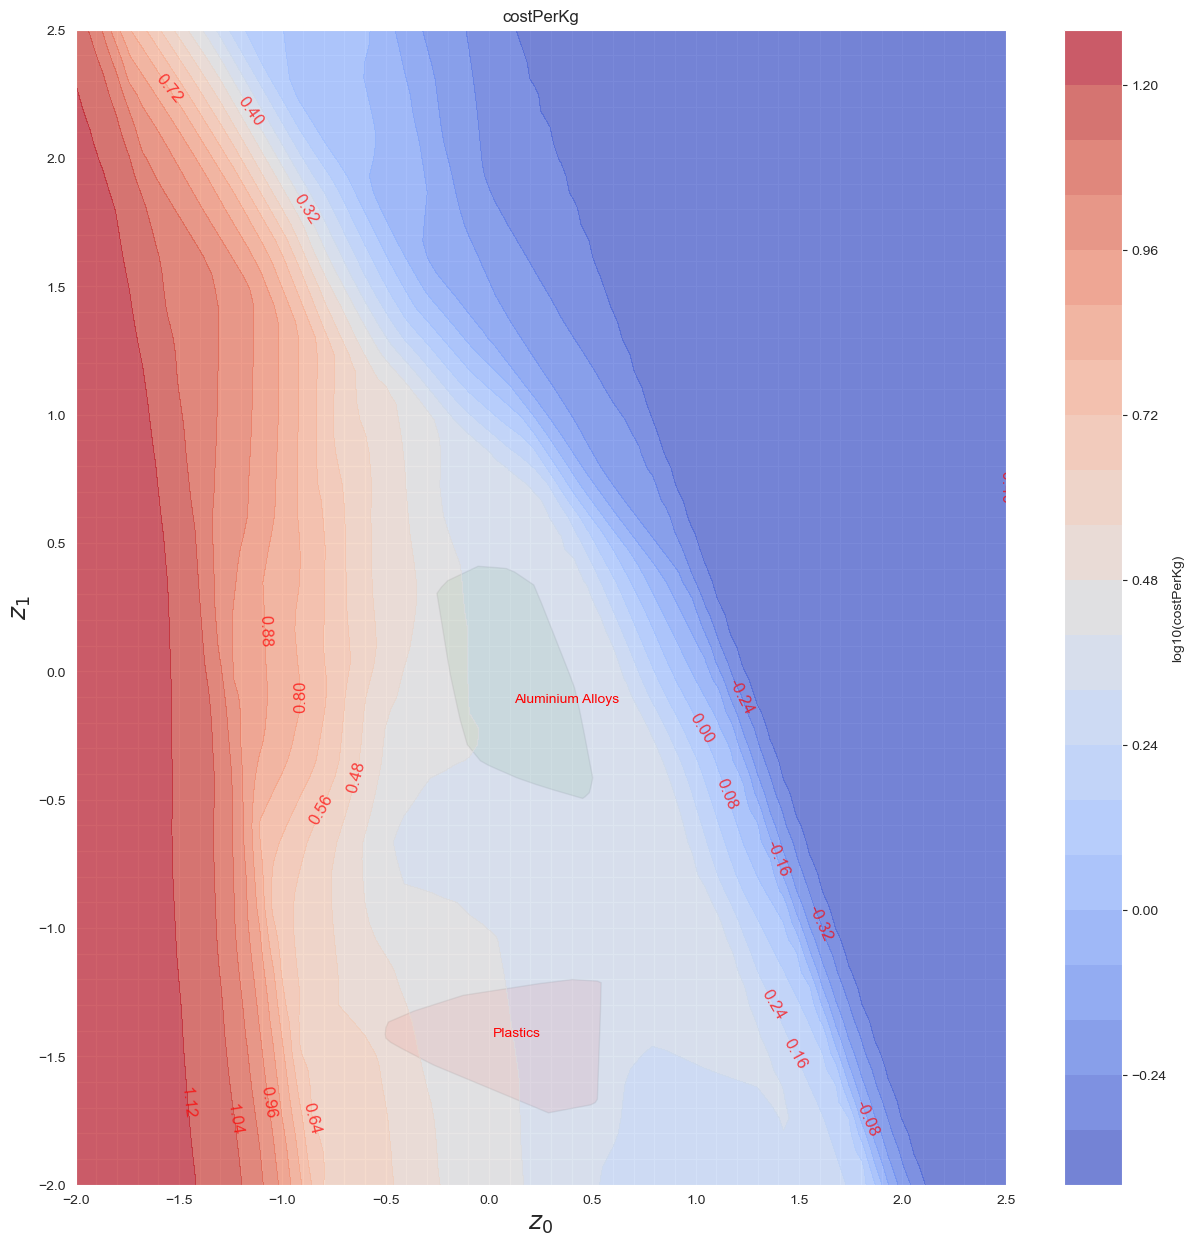

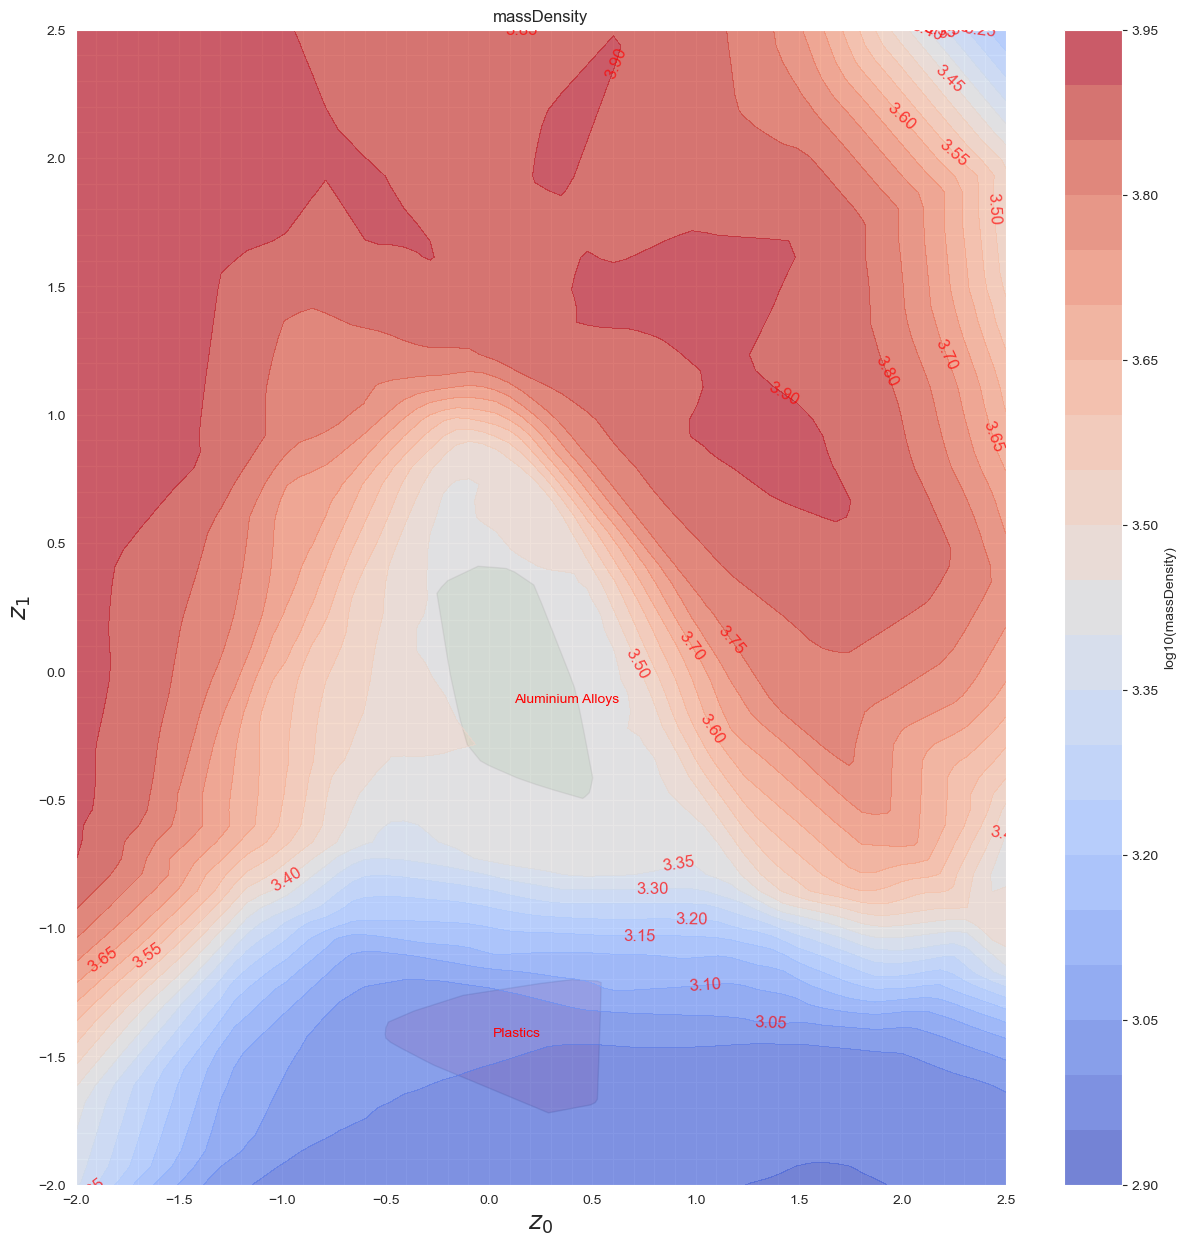

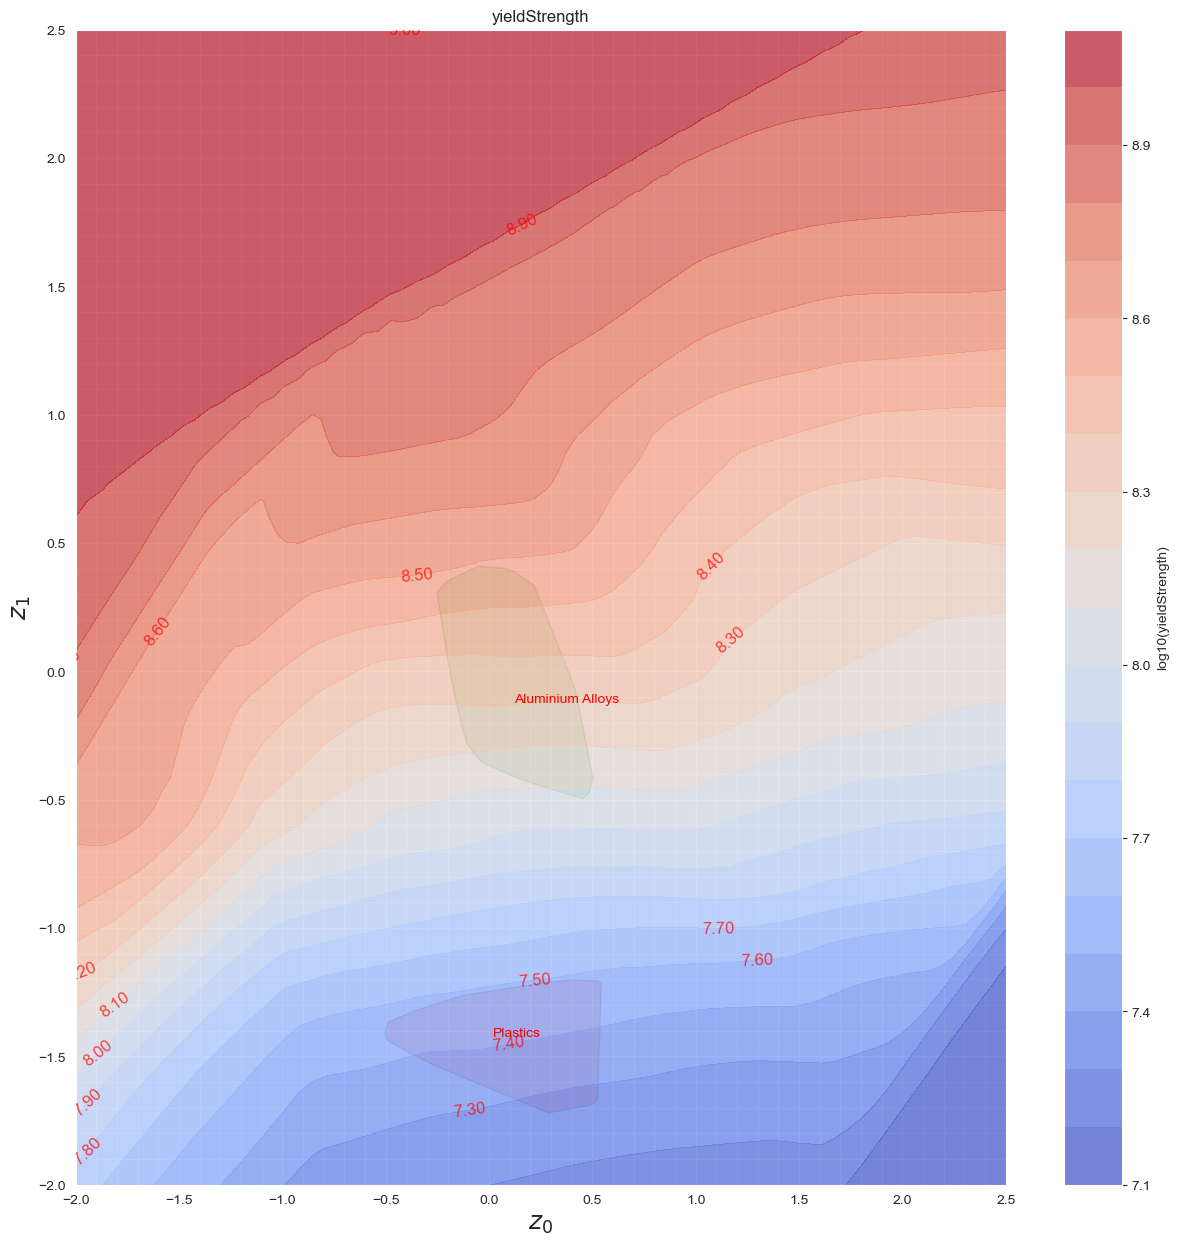

In [29]:
def plotLatentWithProperty(zp):
  n = 80
  zmin, zmax = -2.5,2.5
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim']))
  Z[:,0], Z[:,1] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))
  Z[:,2]=zp
  vae = materialEncoder.vaeNet
  trainData_z_np = to_np(vae.encoder.z)
  decoded = vae.decoder(Z)


  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matPropVal = 10.**(scaleMin + decoded[:,idx]*(scaleMax - scaleMin))

    fig, ax = plotLatentProy(zp, saveFileName = './figures/swrksLatent.pdf')
    surf = ax.contourf(X, Y, np.log10(to_np(matPropVal).reshape((n,n))), levels = 20, cmap='coolwarm', alpha = 0.7)
    plt.clabel(surf, inline=False, fontsize=12, fmt ='%0.2F', colors = 'red')
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_1$')
    ax.set_title(p)
    cbar = plt.colorbar(surf)
    cbar.set_label('log10({:s})'.format(str(p)))
    plt.savefig('./figures/{:s}_latentField.pdf'.format(p), dpi=200, bbox_inches='tight')

  #-------------------------------------------#
  
plotLatentWithProperty(0)

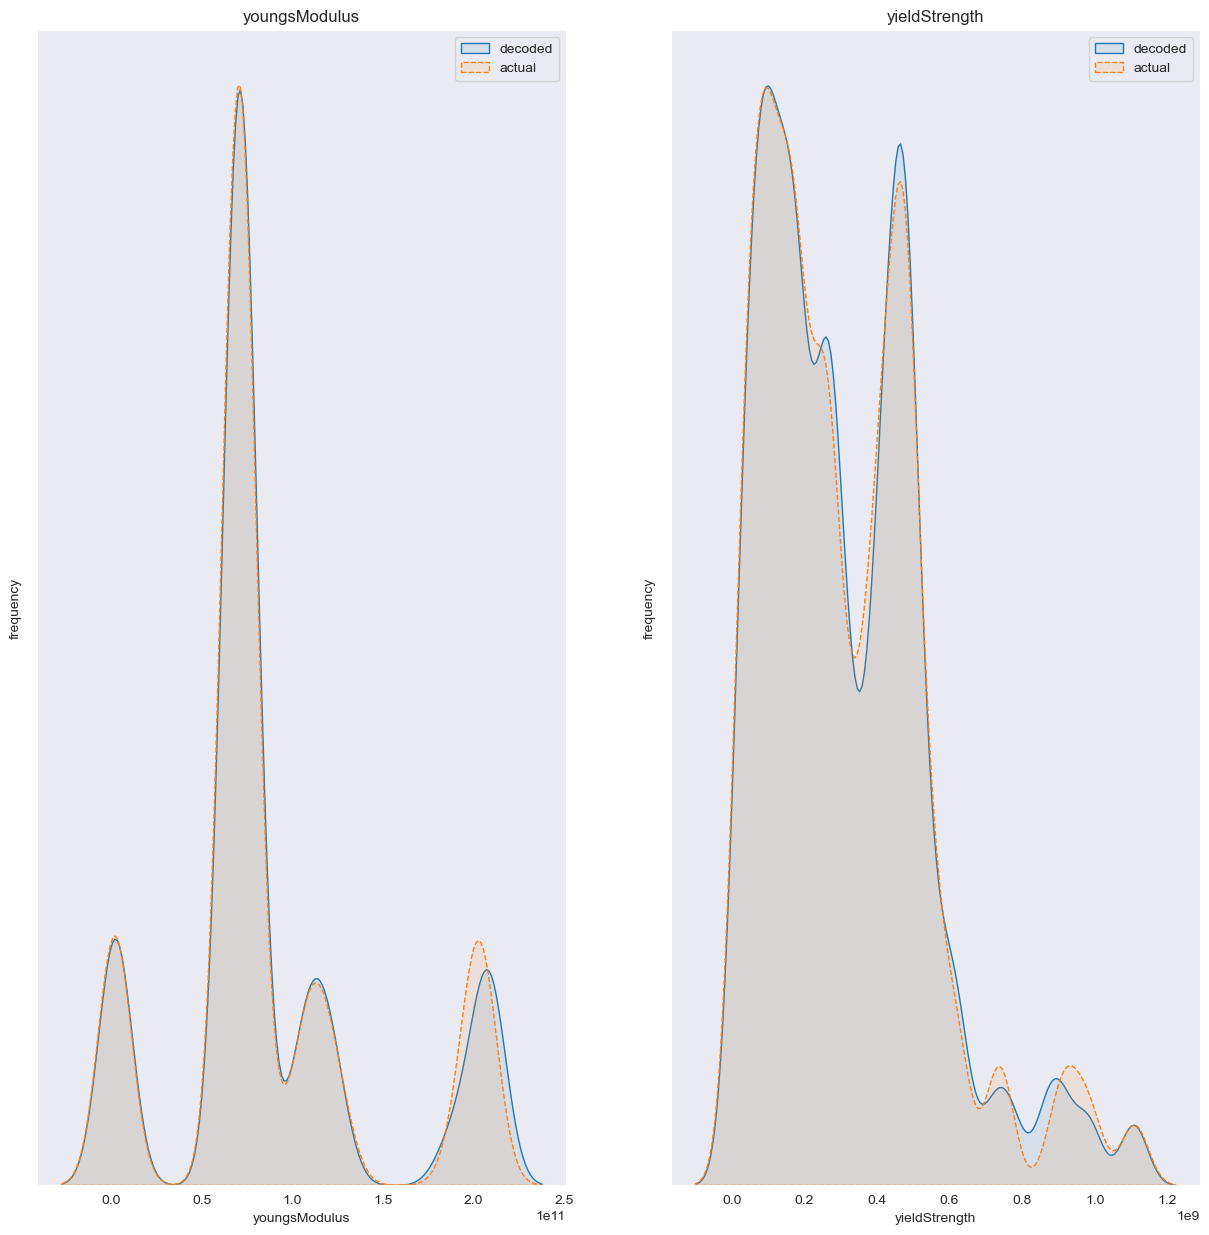

In [30]:
def plotTrueAndReconstructedDistribution():

  vae = materialEncoder.vaeNet
  trainData_z_np = to_np(vae.encoder.z)
  decodedVals = vae.decoder(vae.encoder.z)
  
  bw = 0.405
  fig, ax = plt.subplots(1,2)
  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  props = ['youngsModulus','yieldStrength']
  for ctr, p in enumerate(props):
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matVal_decoded = 10.**(scaleMin + decodedVals[:,idx]*(scaleMax - scaleMin))
    matVal_data = 10.**(scaleMin + trainingData[:,idx]*(scaleMax - scaleMin))

    #sns.set_style('white')
    plt.subplot(1,2,ctr+1)
    f = sns.kdeplot(to_np(matVal_decoded), bw_adjust=bw, fill = True, alpha = 0.1, label='decoded')
    f = sns.kdeplot(to_np(matVal_data), bw_adjust=bw,  fill = True, alpha = 0.1, linestyle="--", label='actual')
    f.set(xlabel = p, ylabel = 'frequency',yticklabels=[])
    plt.legend()
    plt.axis('auto')
    plt.title(p)
  
  plt.savefig('./figures/trueAndReconstructedDistribution.pdf'.format(p), dpi=200, bbox_inches='tight')

plotTrueAndReconstructedDistribution()  

C:\Users\luisy\AppData\Local\Temp\ipykernel_15284\3436119189.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z, requires_grad = True)
C:\Users\luisy\AppData\Local\Temp\ipykernel_15284\3436119189.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z, requires_grad = True)
C:\Users\luisy\AppData\Local\Temp\ipykernel_15284\3436119189.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z, requires_grad = True)


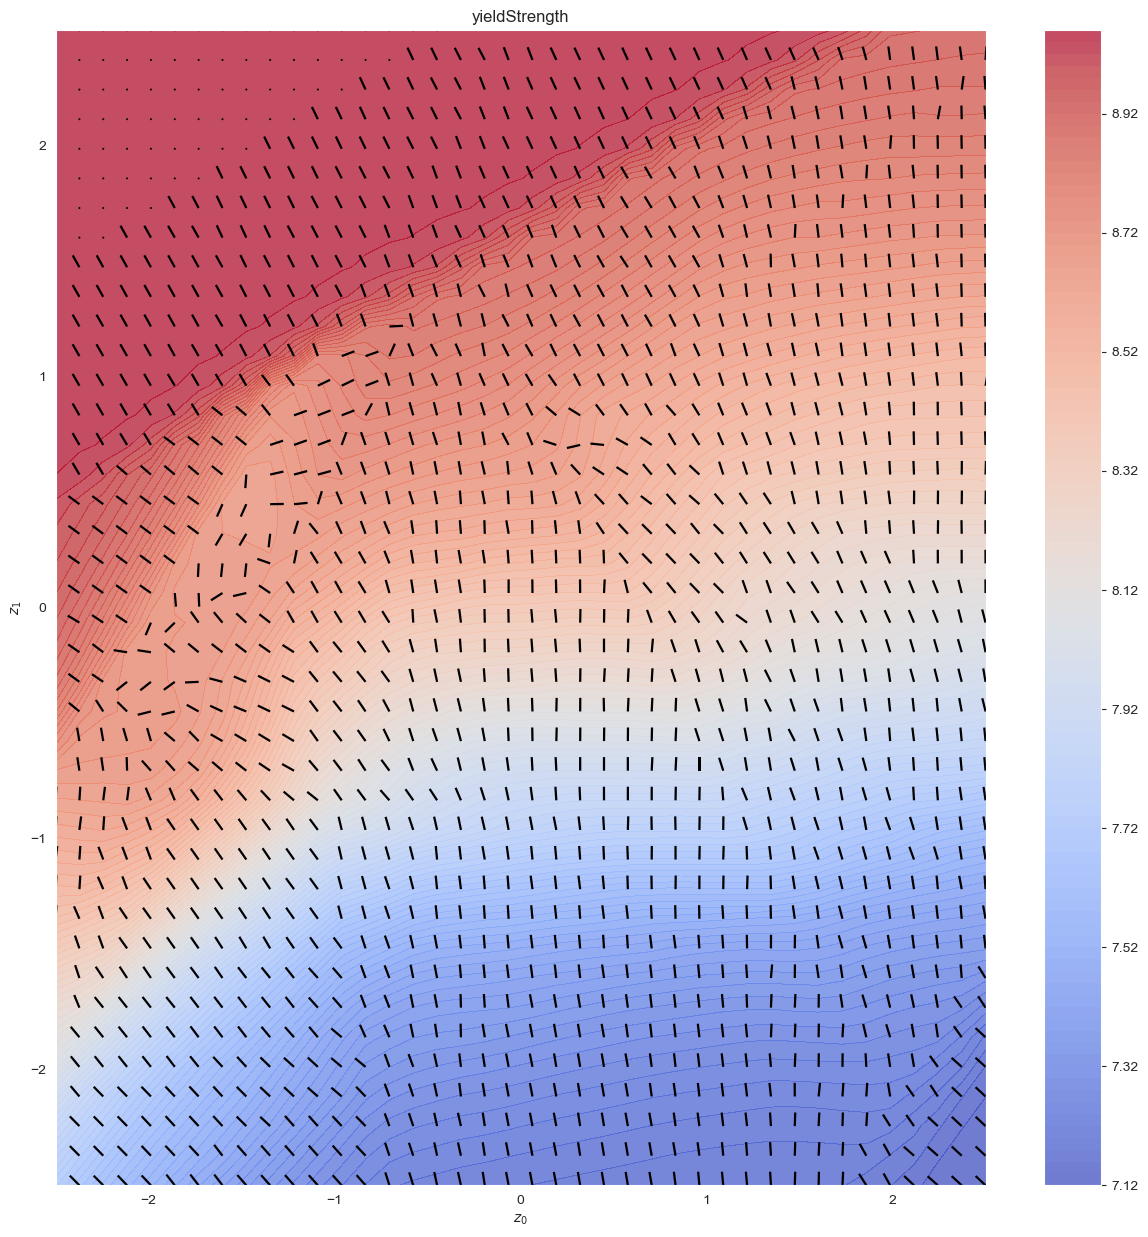

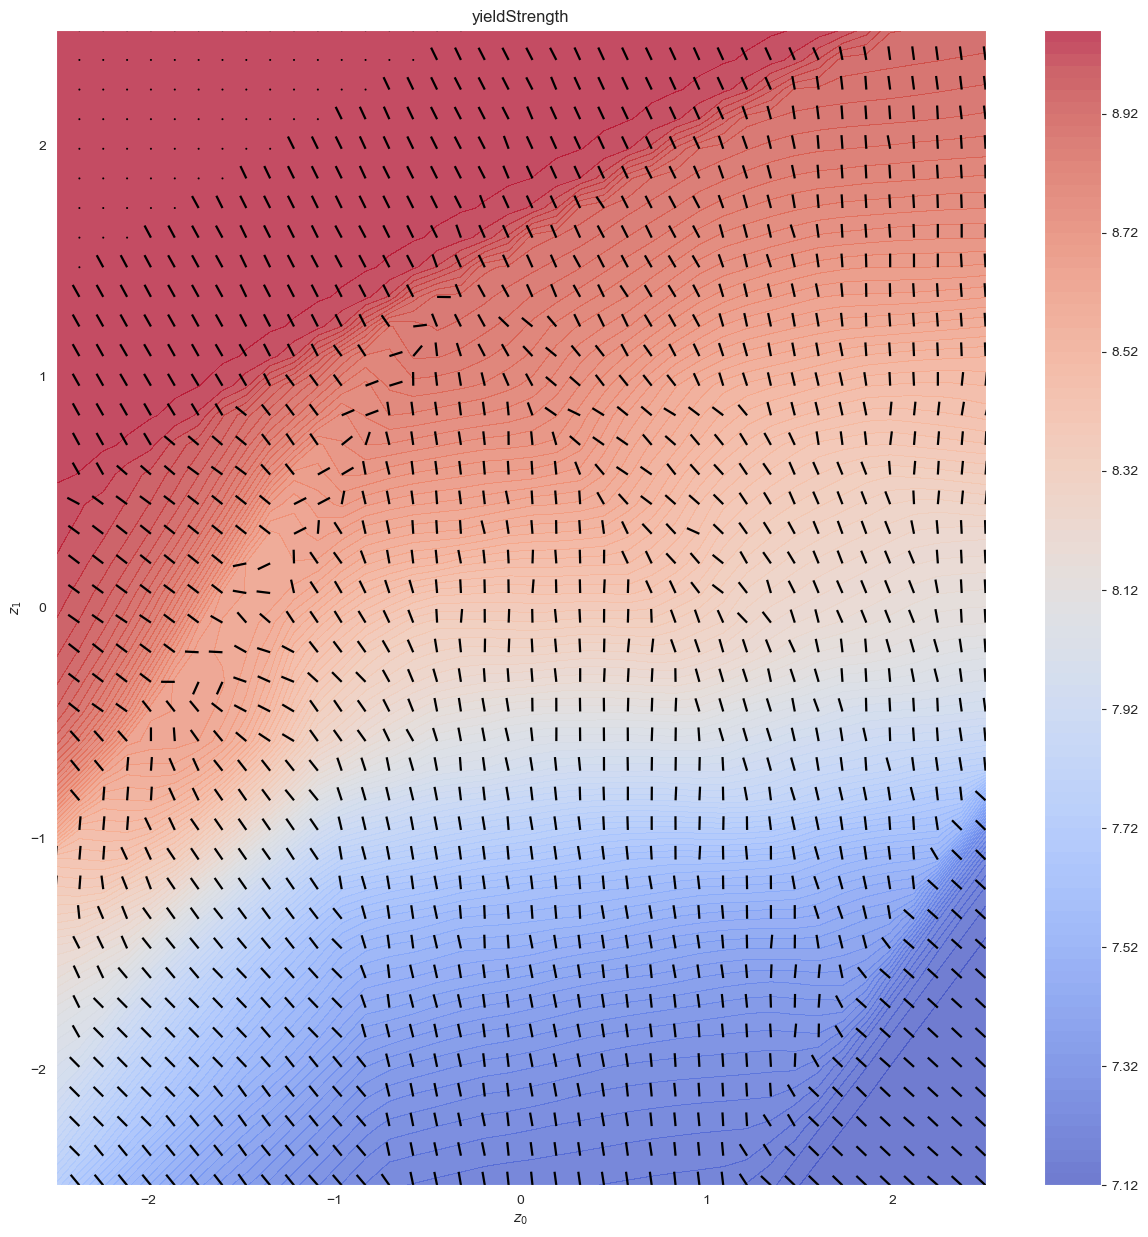

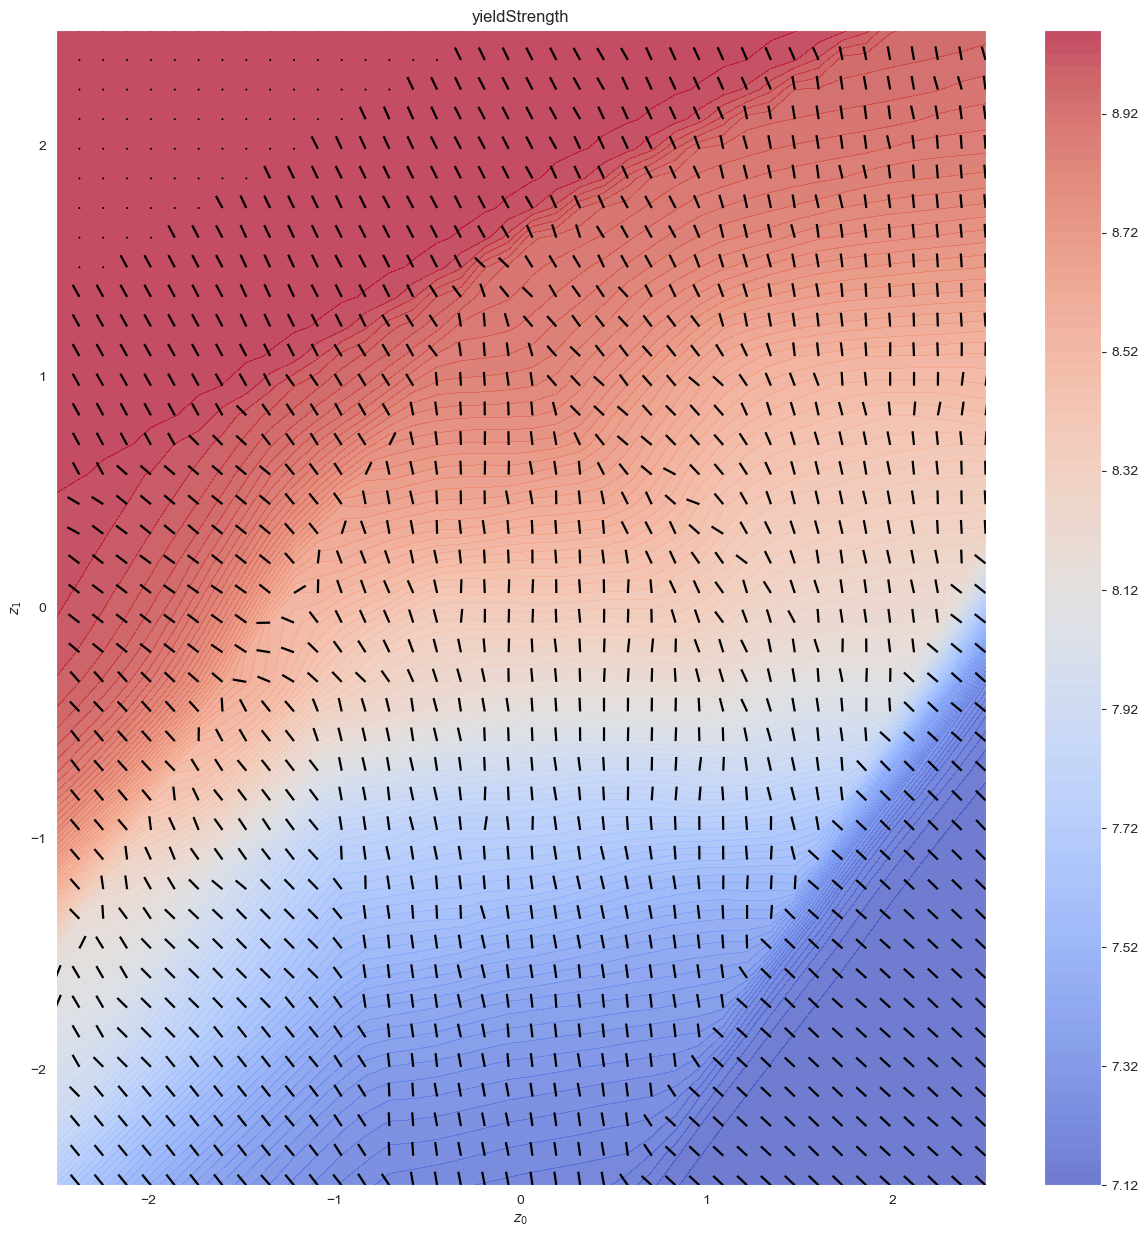

In [35]:
def plotLatentPropertyWithGradients(zp):
  n = 40
  zmin, zmax = -2.5,2.5
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim']))
  Z[:,0], Z[:,1] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))
  Z[:,2]=zp
  Z = torch.tensor(Z, requires_grad = True)
  vae = materialEncoder.vaeNet
  decodedVals = vae.decoder(Z)



  fig, ax = plt.subplots(1,1)
  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  props = ['yieldStrength']
  for ctr, p in enumerate(props):
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matVal_decoded = 10.**(scaleMin + decodedVals[:,idx]*(scaleMax - scaleMin))

    dE_dz = to_np(torch.autograd.grad(matVal_decoded, Z, grad_outputs = torch.ones(Z.shape[0]), create_graph = True)[0])
    U = dE_dz[:,0] / (1e-4+np.sqrt(dE_dz[:,0]**2 + dE_dz[:,1]**2))
    V = dE_dz[:,1] / (1e-4+np.sqrt(dE_dz[:,0]**2 + dE_dz[:,1]**2))
    plt.subplot(1,1,ctr+1)
    surf = plt.contourf(X, Y, np.log10(to_np(matVal_decoded).reshape((n,n))), levels = 100, cmap='coolwarm', alpha = 0.7)
    plt.quiver(X,Y,U,V, headwidth = 0, headlength = 0,headaxislength = 0, color = 'black')
#     plt.clabel(surf, inline=False, fontsize=12, fmt ='%0.2F', colors = 'black')
    plt.title(p)
    plt.xlabel('$z_0$')
    plt.ylabel('$z_1$')
    cbar = plt.colorbar(surf)
#     cbar.set_label('$log_{10}$({:s})'.format(p))
  
  plt.savefig('./figures/latentSpaceGradient.pdf'.format(p), dpi=200, bbox_inches='tight')
plotLatentPropertyWithGradients(-0.5)
plotLatentPropertyWithGradients(0)
plotLatentPropertyWithGradients(0.5)